# Packages

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Test of stationarity
from statsmodels.tsa.stattools import adfuller


# Functions

In [27]:
def split_and_expand(row):
    """Split a string data accross coma
    """
    return pd.Series(row.split(','))   

def raw_data_to_dataframe(df_unseparated):
    """From a raw DataFrame returns a clean DataFrame separated on the coma.
    """ 

    columns_name = df_unseparated.columns[0].split(',')

    values = df_unseparated['Date,Open,High,Low,Close,Adj Close,Volume'].apply(split_and_expand).values

    return pd.DataFrame(values, columns=columns_name)

def df_of_aggregated_data(df_raw):
    """From Yahoo.fr export, returns a dataframe with the asset as ticker.
    """
    df_aggregated = pd.DataFrame()

    for indice in list(df_raw.keys()):
        df_raw[indice] = raw_data_to_dataframe(df_raw[indice])
        # Add the ticker on the dataframe
        df_raw[indice]['Ticker'] = [indice]*len(df_raw[indice])
        # concat all the data frame
        df_aggregated = pd.concat([df_aggregated, df_raw[indice]], axis=0)

    return df_aggregated.set_index('Date')


def convert_index_to_datetime(df):
    """
    Convert the index of a DataFrame from a string date format (YYYY-MM-DD) to datetime format.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - pandas DataFrame with the index converted to datetime format
    """
    # Check if the DataFrame has an index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert the index to datetime format
        df.index = pd.to_datetime(df.index)
    
    return df
    
def transform_df_with_str_values_into_float(df, columns_to_change):
    df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')
    return df

def crop_dataframe(df, begin_date='1000-01-01', end_date='3000-01-01', all_dates=False):
    """
    Crop a DataFrame between two specified dates, keeping all occurrences of the dates if specified.

    Parameters:
    - df: pandas DataFrame
    - begin_date: str, format 'YYYY-MM-DD'
    - end_date: str, format 'YYYY-MM-DD'
    - all_dates: bool, if True, keep all data, regardless of the date interval (default: False)

    Returns:
    - pandas DataFrame cropped between begin_date and end_date (or the original DataFrame if all_dates is True)
    """
    # If all_dates is True, return the original DataFrame
    if all_dates:
        return df
    
    else:
        # Convert input dates to datetime format
        begin_date = pd.to_datetime(begin_date)
        end_date = pd.to_datetime(end_date)

        # Boolean indexing to keep all occurrences of dates within the specified interval
        cropped_df = df[(df.index >= begin_date) & (df.index <= end_date)]

        return cropped_df


# Download and clean data

In [28]:
DATA_PATH = "/Users/antoine/Documents/GitHub/Allocation_de_portefeuille_sous_contrainte_ESG/data/StockPrice_JPM_AAPL_BP.xlsx"

In [29]:
df = pd.read_excel(DATA_PATH, sheet_name=None)
df_aggregated = df_of_aggregated_data(df)
df_aggregated_in_datetime = convert_index_to_datetime(df_aggregated)
df_clean = transform_df_with_str_values_into_float(df_aggregated_in_datetime, columns_to_change = df_aggregated_in_datetime.columns.drop('Ticker'))

In [30]:
df_clean

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
1985-01-01,0.130022,0.138951,0.124442,0.129464,0.100314,6366416000,AAPL
1985-02-01,0.129464,0.137277,0.110491,0.110491,0.085613,4733388800,AAPL
1985-03-01,0.110491,0.116071,0.092634,0.098772,0.076533,4615587200,AAPL
1985-04-01,0.098772,0.102679,0.087612,0.094866,0.073506,2868028800,AAPL
1985-05-01,0.094866,0.099330,0.075335,0.077567,0.060102,4639129600,AAPL
...,...,...,...,...,...,...,...
2023-07-01,146.190002,159.380005,141.440002,157.960007,155.733475,231241600,JPM
2023-08-01,157.429993,158.000000,145.460007,146.330002,145.258163,169302400,JPM
2023-09-01,146.089996,150.250000,142.649994,145.020004,143.957764,172196500,JPM


# Plot index evolution

In [31]:
VALUE_TO_PLOT = 'Adj Close'
BEGIN_DATE = '2020-01-01'
END_DATE = '2023-12-01'

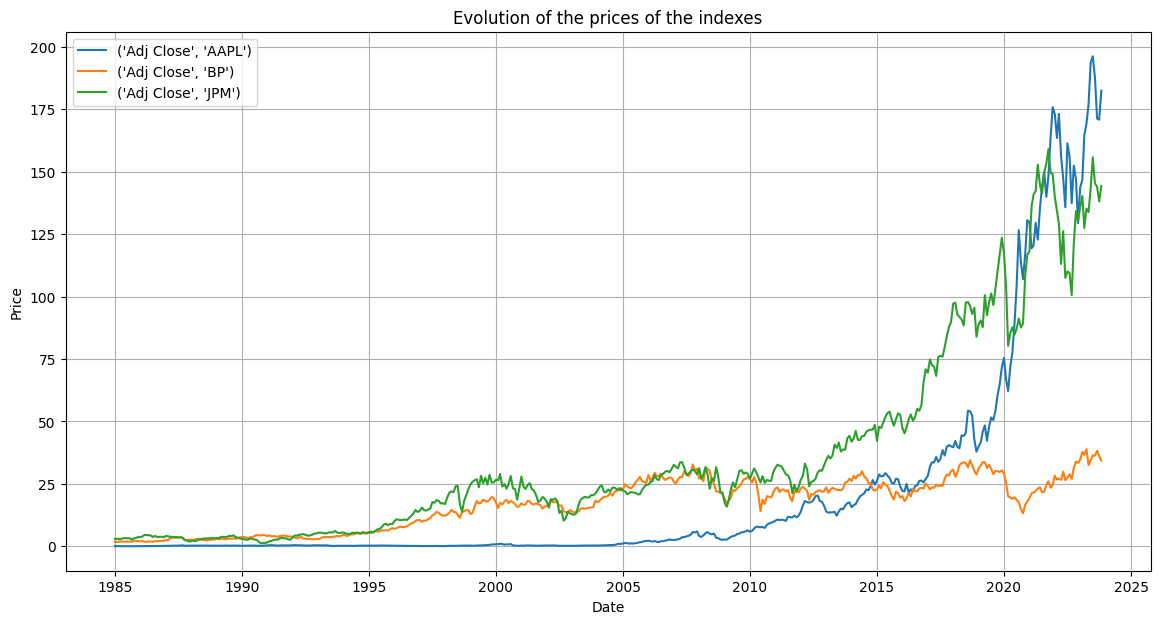

In [32]:
# df_cropped = crop_dataframe(df_clean, BEGIN_DATE, END_DATE, all_dates=False)
df_cropped = crop_dataframe(df_clean, all_dates=True)

table = df_cropped[[VALUE_TO_PLOT,'Ticker']].pivot(columns='Ticker')

plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], label=c)
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of the prices of the indexes')
plt.show()

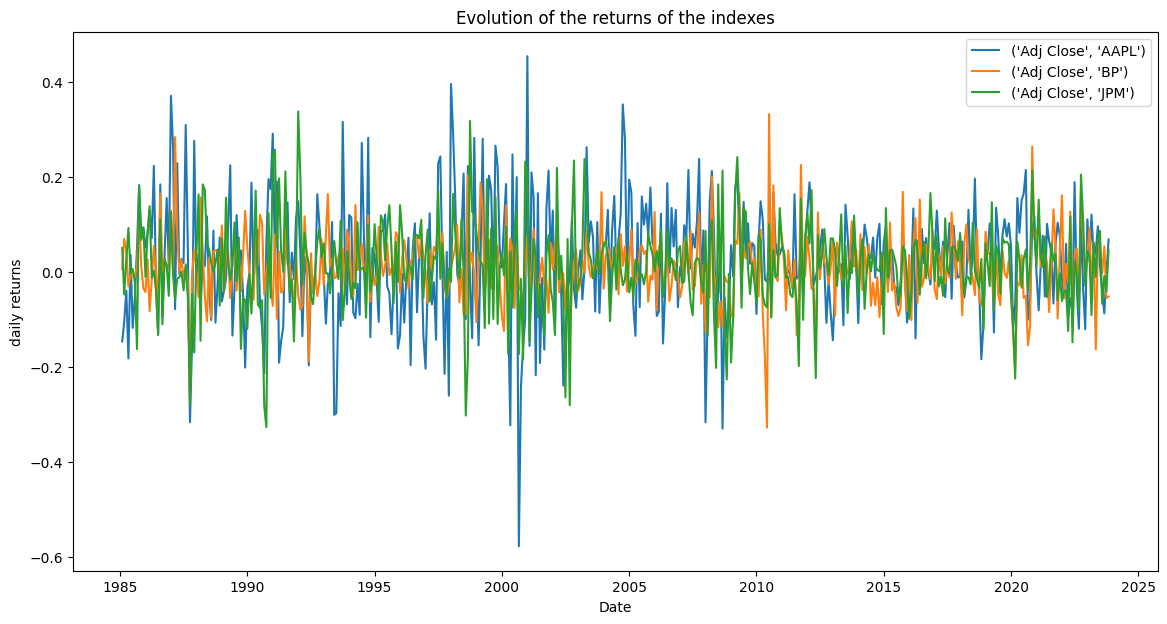

In [34]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], label=c)
plt.legend()
plt.ylabel('daily returns')
plt.xlabel('Date')
plt.title('Evolution of the returns of the indexes')
plt.show()

# Efficient frontier representation

## Test the stationarity of the returns

In [89]:
# For testing stationarity
P_VALUE = 0.01

In [99]:
Y = returns+1
Y_full = Y.iloc[1:]

for index in Y.columns:
    # ADF Test for Stationarity
    result = adfuller(Y_full[index].values, autolag='AIC')

    # Extract and print the results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('__________________________')
    print(f'Stationarity test for {index[1]} index')
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpret the results
    if p_value <= P_VALUE:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely stationary (reject the null hypothesis of non-stationarity).')
    else:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely non-stationary (fail to reject the null hypothesis).')

__________________________
Stationarity test for AAPL index
ADF Statistic: -20.259515523471876
p-value: 0.0
Critical Values:
   1%: -3.4444914328761977
   5%: -2.8677756786103683
   10%: -2.570091378194011
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
__________________________
Stationarity test for BP index
ADF Statistic: -23.200931567622092
p-value: 0.0
Critical Values:
   1%: -3.4444914328761977
   5%: -2.8677756786103683
   10%: -2.570091378194011
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
__________________________
Stationarity test for JPM index
ADF Statistic: -12.4507046285143
p-value: 3.580768474218461e-23
Critical Values:
   1%: -3.444583778100581
   5%: -2.8678163032301995
   10%: -2.570113030490433
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).


## Empirical moments

In [112]:
TIME_T = '2023-11-01'

In [178]:
def get_mu_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat_TIME_T = gross_returns_table.loc[:pd.to_datetime(end_date_for_the_empirical_sum)].mean(axis=0)
    return mu_hat_TIME_T.values

def get_omega_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat = get_mu_hat(gross_returns_table=gross_returns_table, end_date_for_the_empirical_sum=end_date_for_the_empirical_sum)
    Y_minus_mu_hat = gross_returns_table - mu_hat

    omega_hat = np.zeros((len(Y_minus_mu_hat.columns),len(Y_minus_mu_hat.columns)))
    
    for date in Y_minus_mu_hat.index:
        Y_date_minus_mu_hat = Y_minus_mu_hat.loc[date].values.reshape(len(Y_minus_mu_hat.columns), 1)
        matrix_product_for_date = np.dot(Y_date_minus_mu_hat, Y_date_minus_mu_hat.T)
        omega_hat += matrix_product_for_date

    omega_hat /= len(omega_hat)
    
    return omega_hat


In [179]:
mu_hat = get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
mu_hat

array([1.02391826, 1.00904192, 1.01267935])

In [180]:
omega_hat =get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
omega_hat

array([[2.32812929, 0.29284119, 0.41446736],
       [0.29284119, 0.82499217, 0.28690208],
       [0.41446736, 0.28690208, 1.31187725]])